# Epidemic spreading on graphs

In [71]:
import warnings
warnings.filterwarnings("ignore")

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import EoN
import pickle
import sys


sys.path.append('../')
from src.generateGraphs import *
from src.utils import *
from src.perc import jaccard_iterators

np.set_printoptions(legacy='1.25')

fig_directory = '../../Note/Notes/Figures/06_epi/'

> **NOTE**: you must run the following command since `EoN` is not part of the environment
>
>```bash
>conda activate CSS
>pip install EoN
>```

## Running an epidemic spreading on a graph

To run a simulation of an epidemic spreading on a graph, we use the `EoN` (epidemics on networks) package which provides very efficient packages to do so. We first consider an Erdos-Renyi random graph and look at the curves $S_(t), I(t), R(t)$. 

In [2]:
# size and avreage degree
n, d = 10**4, 30

# get the graph
A = fastER(n, c = d)
G = nx.from_scipy_sparse_array(A)

#  infection rate, recovery rate, temporal resolution
β, μ, dt = 0.15, 1, 0.3

# select the seeds
n_seeds = 5
r = np.random.choice(np.arange(n), n_seeds, replace = False)

# run the simulation
t, S, I, R = EoN.Gillespie_SIR(G, β*dt, μ*dt, initial_infecteds = r, tmax = 200)

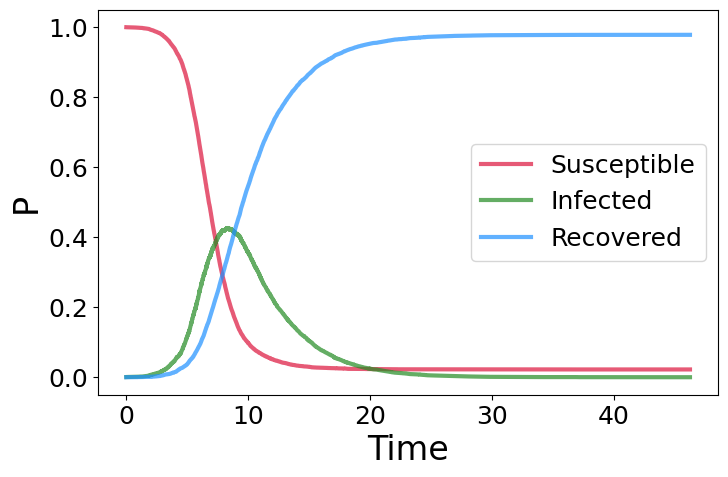

In [3]:
# PLOT

plt.figure(figsize = (8, 5))
plt.plot(t, S/n, color = 'crimson', label = 'Susceptible', linewidth = 3, alpha = 0.7)
plt.plot(t, I/n, color = 'forestgreen', label = 'Infected', linewidth = 3, alpha = 0.7)
plt.plot(t, R/n, color = 'dodgerblue', label = 'Recovered', linewidth = 3, alpha = 0.7)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.xlabel('Time', fontsize = 24)
plt.ylabel('P', fontsize = 24)

plt.legend(fontsize = 18)
plt.show();

## Epidemic threshold

We analyze the epidemic burden (i.e. the fraction of individuals that at the end of the spreading are not susceptible and hence that were hit by the epidemic) as a function of the transmissibility parameter. We consider a dense and a sparse graph from the configuration model and we infect $20$ nodes at the beginning with a probability proportional to their degree. This is to ensure a vanishing probabability that the epidemic dies out if the parameters $\beta$ and $\mu$ are so that $R_0 > 1$.

In [ ]:
###########################################
############ DENSE GRAPH ##################
###########################################

# size and average degree
n, d = 10**5, 100

# generate a heterogeneous degree sequence
θ = np.random.uniform(3, 12, n)**6

# generate the graph and the adjacency matrix
G = nx.expected_degree_graph(θ/np.mean(θ)*d)
A = nx.adjacency_matrix(G)
deg_sequence = A@np.ones(n)

# we infect r nodes with a probability proportional to their degree
r = 20
r = np.random.choice(np.arange(n), r, p = deg_sequence/np.sum(deg_sequence))

# we try several values of β 
βv = np.linspace(0.001, 0.01, 15)

res_dense = []

for i, β in enumerate(βv):

    # print progress bar
    print("[%-25s] %d%%" % ('='*(int((i+1)/len(βv)*25)-1) + '>', (i+1)/(len(βv))*100), end = '\r')

    # run the simulation    
    t, S, I, R = EoN.Gillespie_SIR(G, β*dt, μ*dt, initial_infecteds = r, tmax = 500)

    # we save the fraction of people that have been "touched" by the epidemic
    res_dense.append(1-S[-1]/n)


# ###########################################
# ############ SPARSE GRAPH #################
# ###########################################

# size and average degree
n, d = 10**5, 3

# generate a heterogeneous degree sequence
θ = np.random.uniform(3, 12, n)**6

# generate the graph and the adjacency matrix
G = nx.expected_degree_graph(θ/np.mean(θ)*d)
A_sparse = nx.adjacency_matrix(G)
deg_sequence = A_sparse@np.ones(n)

# we infect r nodes with a probability proportional to their degree
r = 20
r = np.random.choice(np.arange(n), r, p = deg_sequence/np.sum(deg_sequence))

# we try several values of β 
βv_sparse = np.linspace(0.05, 0.18, 15)

res_sparse = []

for i, β in enumerate(βv_sparse):
    # print progress bar
    print("[%-25s] %d%%" % ('='*(int((i+1)/len(βv_sparse)*25)-1) + '>', (i+1)/(len(βv_sparse))*100), end = '\r')

    # run the simulation    
    t, S, I, R = EoN.Gillespie_SIR(G, β*dt, μ*dt, initial_infecteds = r, tmax = 500)

    # we save the fraction of people that have been "touched" by the epidemic
    res_sparse.append(1-S[-1]/n)

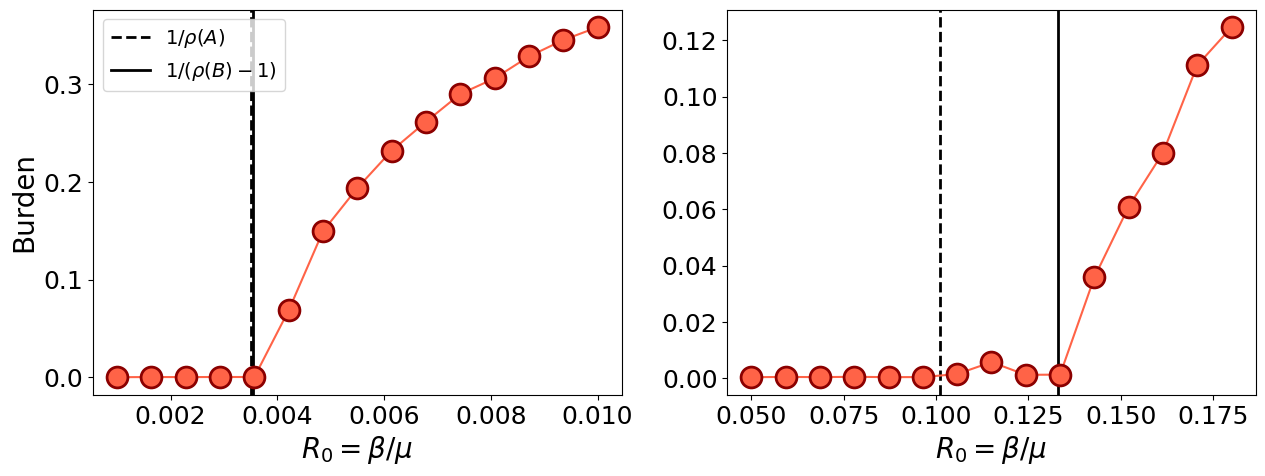

In [12]:
# PLOT
fig, ax = plt.subplots(1,2, figsize = (15, 5))

ρA = SpectralRadius(A)
ρB = SpectralRadiusNB(A)
ax[0].plot(βv/μ, res_dense, marker = 'o', color = 'tomato', markersize = 15, markeredgecolor = 'darkred', markeredgewidth = 2, zorder = 3)
ax[0].axvline(1/ρA, color = 'k', linewidth = 2, linestyle = '--', label = r'$1/\rho(A)$')
ax[0].axvline(1/(ρB-1), color = 'k', linewidth = 2, linestyle = '-', label = r'$1/(\rho(B)-1)$')
ax[0].tick_params(axis = 'both', labelsize = 18)
ax[0].set_xlabel(r'$R_0 = \beta/\mu$', fontsize = 20)
ax[0].set_ylabel('Burden', fontsize = 20)
ax[0].legend(fontsize = 14, loc = 2)

ρA = SpectralRadius(A_sparse)
ρB = SpectralRadiusNB(A_sparse)
ax[1].plot(βv_sparse/μ, res_sparse, marker = 'o', color = 'tomato', markersize = 15, markeredgecolor = 'darkred', markeredgewidth = 2, zorder = 3)
ax[1].axvline(1/ρA, color = 'k', linewidth = 2, linestyle = '--')
ax[1].axvline(1/(ρB-1), color = 'k', linewidth = 2, linestyle = '-')
ax[1].tick_params(axis = 'both', labelsize = 18)
ax[1].set_xlabel(r'$R_0 = \beta/\mu$', fontsize = 20)

plt.savefig(f'{fig_directory}perc_th.pdf', dpi = 400, bbox_inches = 'tight')

plt.show();

## Role of the degree

Here we show the hitting time (i.e. the time at which an initially susceptible node gets infected) as a function of its degree on a graph generated from the configuration model. 

In [ ]:
n, d = 30000, 30

# generate a heterogeneous degree sequence
θ = np.random.uniform(3, 20, n)**6
deg_sequence = θ/np.mean(θ)*d

# generate the graph and the adjacency matrix
G = nx.expected_degree_graph(deg_sequence)
A = nx.adjacency_matrix(G)

r = np.random.choice(np.arange(n), 10, replace = False)

β = 0.05
μ = 0.05
dt = .1
# run the simulation    
res = EoN.Gillespie_SIR(G, β*dt, μ*dt, initial_infecteds = r, return_full_data = True)


# compute the hitting time
hitting_time, deg = [], []
d = A@np.ones(n)

for i in range(n):
    if len(res.node_history(i)[0]) > 1:
        hitting_time.append(res.node_history(i)[0][1])
        deg.append(d[i])

deg, hitting_time = np.array(deg), np.array(hitting_time)

# Store data (serialize)
with open('../../Plots/Files/deg_sir.pickle', 'wb') as f:
    pickle.dump([all_d, hitting_time, deg], f)


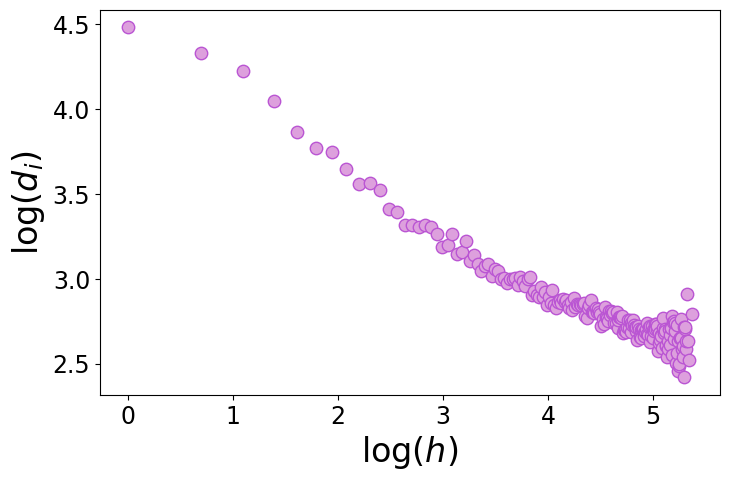

In [186]:
all_d = np.unique(deg)
x, y = np.log(all_d), [np.mean(np.log(hitting_time[deg == x])) for x in all_d]

plt.figure(figsize = (8,5))
plt.scatter(x, y, s = 80, edgecolor = 'mediumorchid', color = 'plum')
plt.xlabel(r'${\rm log}(h)$', fontsize = 24)
plt.xticks(fontsize = 17)
plt.ylabel(r'${\rm log}(d_i)$', fontsize = 24)
plt.yticks(fontsize = 17)


plt.show();

### Vaccination

We now show an vaccination intervention in which a fraction of nodes cannot become infected. We compare the epidemic curve without any vaccination campaing, with a random vaccination campaign and targeting the nodes with higher degree. We model the vaccination by setting some nodes directly to the recovered state at the beginning of the simulation.

In [57]:
# create the graph
n, d = 50000, 30
θ = np.random.uniform(3, 20, n)**6
deg_sequence = θ/np.mean(θ)*d
G = nx.expected_degree_graph(deg_sequence)
A = nx.adjacency_matrix(G)

dt = 0.05
μ = 1.2
β = 0.2
vaccinated_fraction = 0.2

# these are the seeds
r = np.random.choice(np.arange(n), 10, p = deg_sequence/np.sum(deg_sequence))

### No vaccination
t_novax, _, I_novax, _ = EoN.Gillespie_SIR(G, β*dt, μ*dt, initial_infecteds = r, tmax = 500)

### Random vaccination
vaccinated_rdn = np.random.choice(list(set(np.arange(n)) - set(r)), int(n*vaccinated_fraction), replace = False)
t_rdnvax, _, I_rdnvax, _ = EoN.Gillespie_SIR(G, β*dt, μ*dt, initial_infecteds = r, initial_recovereds = vaccinated_rdn, tmax = 500)

### Targeted vaccination
p = deg_sequence[~np.isin(np.arange(n), r)]
vaccinated_target = np.random.choice(list(set(np.arange(n)) - set(r)), int(n*vaccinated_fraction), replace = False, p = p/np.sum(p))
t_target_vax, _, I_target_vax, _ = EoN.Gillespie_SIR(G, β*dt, μ*dt, initial_infecteds = r, initial_recovereds = vaccinated_target, tmax = 500)

# Store data (serialize)
with open('../../Plots/Files/vax.pickle', 'wb') as f:
    pickle.dump([n, t_novax, t_rdnvax, t_target_vax, I_novax, I_rdnvax, I_target_vax], f)

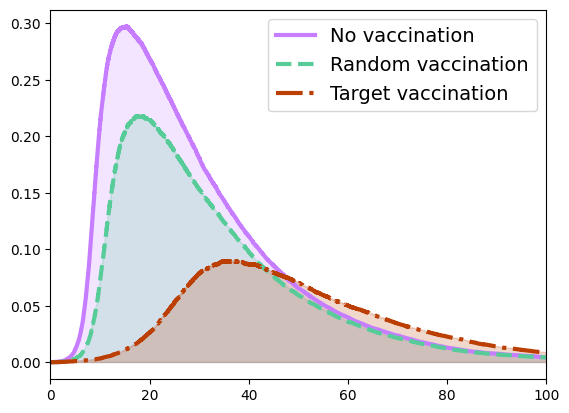

In [55]:
plt.plot(t_novax, I_novax/n, color = '#c77dff', label = 'No vaccination', linewidth = 3)
plt.fill_between(t_novax, 0, I_novax/n, alpha = 0.2, color = '#c77dff')

plt.plot(t_rdnvax, I_rdnvax/n, color = '#57cc99', label = 'Random vaccination', linewidth = 3, linestyle = '--')
plt.fill_between(t_rdnvax, 0, I_rdnvax/n, alpha = 0.2, color = '#57cc99')

plt.plot(t_target_vax, I_target_vax/n, color = '#bb3e03', label = 'Target vaccination', linewidth = 3, linestyle = '-.')
plt.fill_between(t_target_vax, 0, I_target_vax/n, alpha = 0.2, color = '#bb3e03')

plt.legend(fontsize = 14)
plt.xlim(0,100)
plt.show();

## The role of weak ties


We repeat the experiment on a set of Watts-Strogatz random graphs for different rewiring probabilities $p$. 

In [182]:
n = 50000
k = 4
β = 0.05
μ = 0.05
dt = .1
r = np.random.choice(np.arange(n), 1)

pv = np.logspace(-2, np.log10(0.3), 5)
t, I = [], []

for p in pv:
    G = nx.watts_strogatz_graph(n, 2*k, p)
    t_, _, I_, _ = EoN.Gillespie_SIR(G, β*dt, μ*dt, initial_infecteds = r, return_full_data = False)
    t.append(t_)
    I.append(I_)


# Store data (serialize)
with open('../../Plots/Files/WS.pickle', 'wb') as f:
    pickle.dump([pv, n, t, I], f)

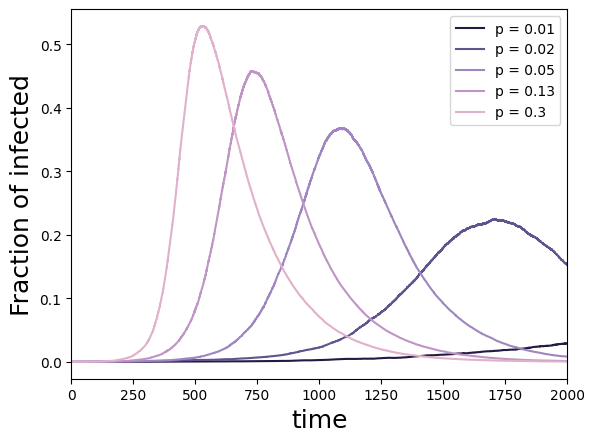

In [151]:
colors = ["231942","5e548e","9f86c0","be95c4","e0b1cb"]
colors = ['#' + v for v in colors]

for i, (t_, I_) in enumerate(zip(t, I)):
    plt.plot(t_, I_/n, color = colors[i], label = f'p = {np.round(pv[i], 2)}')

plt.legend()
plt.xlim(0,2000)
plt.xlabel('time', fontsize = 18)
plt.ylabel('Fraction of infected', fontsize = 18)
plt.show();

### Vaccination

In this case we compute the overlap for each edge $(ij)$ as

\begin{align}
O_{ij} = \frac{|\partial_i\cap\partial_j|}{|\partial_i\cup\partial_j|}
\end{align}

and assign to each node a score $s_i = {\rm min}_j O_{ij}$. A low $s_i$ implies that the node $i$ has a weak tie. From this, we vaccinate nodes with a probability proportional to $1/s_i$ and compare the results with targeted vaccination.

In [183]:
# generate the graph
p = 0.1
G = nx.watts_strogatz_graph(n, 2*k, p)

# compute the overal for all edges and the overlap score for all nodes   
EL = pd.DataFrame(np.array(nx.adjacency_matrix(G).nonzero()).T, columns = ['i', 'j'])
EL['overlap'] = EL.apply(lambda x: jaccard_iterators(G.neighbors(x.i), G.neighbors(x.j)), axis = 1)
min_ov = dict(EL.groupby('i').min().overlap)

### Run the simulation
r = np.random.choice(np.arange(n), 10, p = deg_sequence/np.sum(deg_sequence))

### No vaccination
t_novax, _, I_novax, _ = EoN.Gillespie_SIR(G, β*dt, μ*dt, initial_infecteds = r, tmax = 1500)

### Random vaccination
vaccinated_rdn = np.random.choice(list(set(np.arange(n)) - set(r)), int(n*vaccinated_fraction), replace = False)
t_rdnvax, _, I_rdnvax, _ = EoN.Gillespie_SIR(G, β*dt, μ*dt, initial_infecteds = r, initial_recovereds = vaccinated_rdn, tmax = 1500)

### Targeted vaccination
p = np.array([1/(1e-3+min_ov[x]) for x in np.arange(n) if x not in r])
vaccinated_target = np.random.choice(list(set(np.arange(n)) - set(r)), int(n*vaccinated_fraction), replace = False, p = p/np.sum(p))
t_target_vax, _, I_target_vax, _ = EoN.Gillespie_SIR(G, β*dt, μ*dt, initial_infecteds = r, initial_recovereds = vaccinated_target, tmax = 1500)

# Store data (serialize)
with open('../../Plots/Files/vax_WS.pickle', 'wb') as f:
    pickle.dump([n, t_novax, t_rdnvax, t_target_vax, I_novax, I_rdnvax, I_target_vax], f)

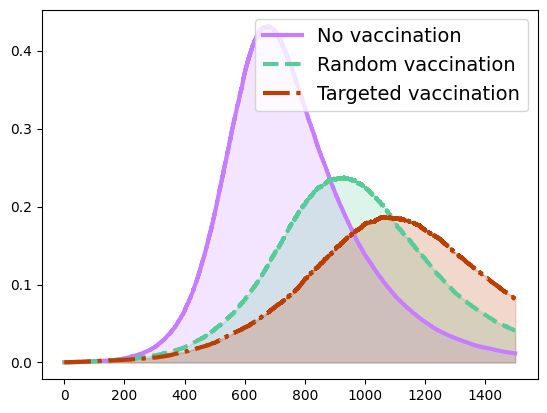

In [184]:
plt.plot(t_novax, I_novax/n, color = '#c77dff', label = 'No vaccination', linewidth = 3)
plt.fill_between(t_novax, 0, I_novax/n, alpha = 0.2, color = '#c77dff')

plt.plot(t_rdnvax, I_rdnvax/n, color = '#57cc99', label = 'Random vaccination', linewidth = 3, linestyle = '--')
plt.fill_between(t_rdnvax, 0, I_rdnvax/n, alpha = 0.2, color = '#57cc99')

plt.plot(t_target_vax, I_target_vax/n, color = '#bb3e03', label = 'Targeted vaccination', linewidth = 3, linestyle = '-.')
plt.fill_between(t_target_vax, 0, I_target_vax/n, alpha = 0.2, color = '#bb3e03')

plt.legend(fontsize = 14)
# plt.xlim(0,100)
plt.show();

## The role of communities

We now run a simulation of an epidemic spreading on a graph with $k=3$ very well separated communities and show that the community structure determines the outcome of an epidemic.

In [273]:
n = 6000
k = 3
sizes = [int(n/k) for i in range(k)]
labels = np.zeros(n)

for i in range(k):
    labels[i*int(n/k):(i+1)*int(n/k)+1] = i

β, μ = 0.004, 0.1

probs = np.ones((k,k))*0.2
probs += np.eye(k)*250
G = nx.stochastic_block_model(sizes, probs/n)

r = np.random.choice(np.arange(n), 1)

res = EoN.Gillespie_SIR(G, β*dt, μ*dt, initial_infecteds = r, return_full_data = True)

###########

hitting_time, lab = [], []

for i in range(n):
    if len(res.node_history(i)[0]) > 1:
        hitting_time.append(res.node_history(i)[0][1])
        lab.append(labels[i])

lab, hitting_time = np.array(lab), np.array(hitting_time)

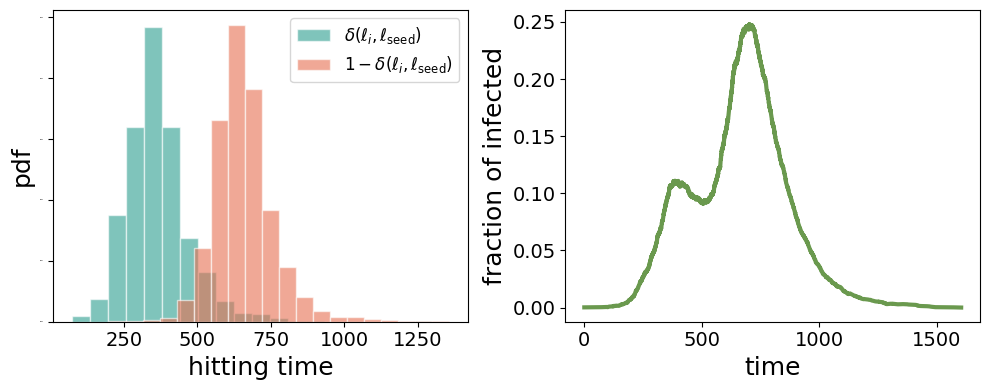

In [274]:
fig, ax = plt.subplots(1, 2, figsize = (10,4))

ax[0].hist(hitting_time[lab == labels[r]], bins = 20, density = True, label = r'$\delta(\ell_i, \ell_{\rm seed})$', edgecolor = 'white',
           alpha = 0.6, color = '#2a9d8f')
ax[0].hist(hitting_time[lab != labels[r]], bins = 20, density = True, label = r'$1-\delta(\ell_i, \ell_{\rm seed})$', edgecolor = 'white',
           alpha = 0.6, color = '#e76f51')
ax[0].legend(fontsize = 12)

ax[0].set_xlabel('hitting time', fontsize = 18)
ax[0].set_ylabel('pdf', fontsize = 18)
ax[0].tick_params(axis='x', which='major', labelsize = 14)
ax[0].tick_params(axis='y', which='major', labelsize = 0)

ax[1].plot(res.t(), res.I()/n, color = '#6a994e', linewidth = 3)
ax[1].set_xlabel('time', fontsize = 18)
ax[1].set_ylabel('fraction of infected', fontsize = 18)
ax[1].tick_params(axis='both', which='major', labelsize = 14)

plt.tight_layout()
plt.savefig(f'{fig_directory}sbm.pdf', dpi = 400, bbox_inches = 'tight')

plt.show();